In [1]:
import tensorflow as tf

2025-03-12 16:31:30.352411: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 16:31:30.381426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741793490.405178   13720 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741793490.412528   13720 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 16:31:30.437137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tf.config.optimizer.set_jit(True)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory limit for the first GPU (adjust MB as needed)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5500)]  # Adjust VRAM allocation
        )
        print("GPU memory limit set to 5500MB")
    except RuntimeError as e:
        print(e)

GPU memory limit set to 5500MB


In [3]:
train_path = 'dataset/training_set'
test_path = 'dataset/test_set'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(128, 128),
  batch_size=32
  )

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(128, 128),
  batch_size=32
  )

Found 8000 files belonging to 2 classes.
Using 6400 files for training.


I0000 00:00:1741793495.630093   13720 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5500 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 2000 files belonging to 2 classes.
Using 400 files for validation.


In [4]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32,)


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [53]:
tf.random.set_seed(123)

In [64]:
from functools import partial

DefaultConv2D = partial(layers.Conv2D, kernel_size=3, padding="same", activation="relu", kernel_initializer='he_normal')

model = Sequential([
    layers.Input(shape=(128,128,3)),
    # data_augmentation,
    layers.Rescaling(1./255),
    DefaultConv2D(filters=16, kernel_size=5),
    DefaultConv2D(filters=16),
    layers.MaxPool2D(),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=32),
    layers.MaxPool2D(),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_16 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_144 (Conv2D)             │ (None, 128, 128, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_146 (Conv2D)             │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_147 (Conv2D)             │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,393 (8.63 MB)

 Trainable params: 2,261,393 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [65]:
epochs=100
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5131 - loss: 0.8534 - val_accuracy: 0.4900 - val_loss: 0.7073
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5191 - loss: 0.6927 - val_accuracy: 0.5900 - val_loss: 0.6725
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5770 - loss: 0.6735 - val_accuracy: 0.6700 - val_loss: 0.6223
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6660 - loss: 0.6208 - val_accuracy: 0.6150 - val_loss: 0.6581
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6407 - loss: 0.6268 - val_accuracy: 0.7350 - val_loss: 0.5548
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7516 - loss: 0.5161 - val_accuracy: 0.7275 - val_loss: 0.5292
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7721 - loss: 0.4825 - val_accuracy: 0.7475 - val_loss: 0.5180
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8035 - loss: 0.4257 -

In [22]:
import matplotlib.pyplot as plt

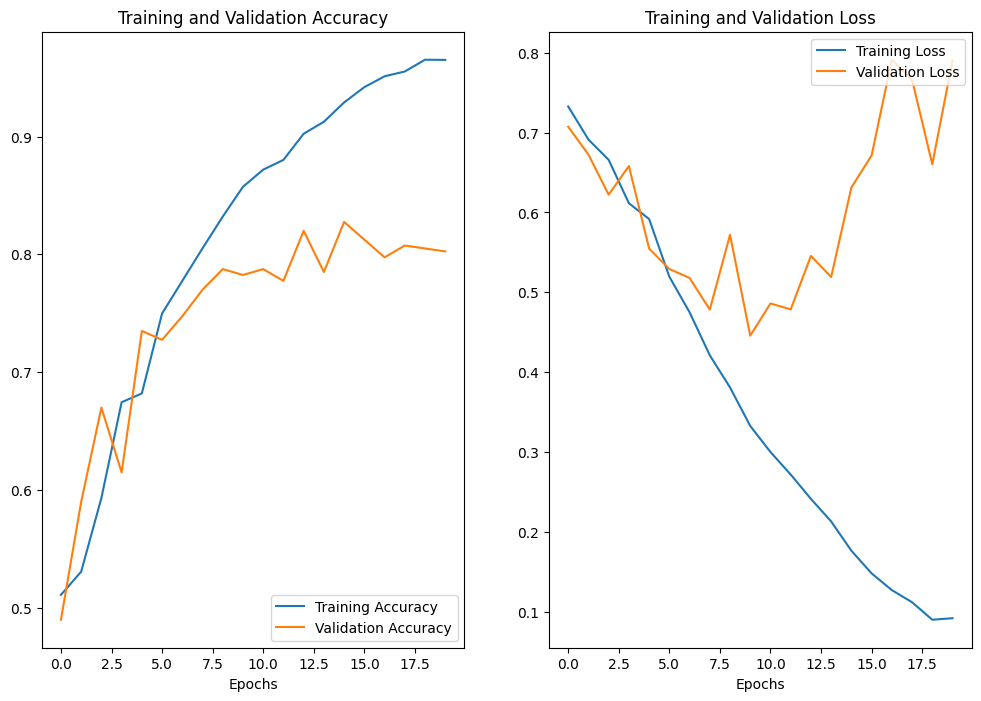

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()

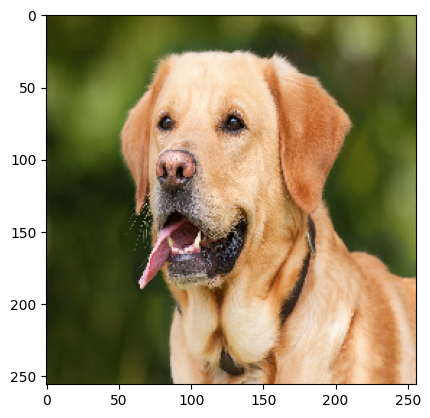

In [67]:
from keras.preprocessing import image

test_img1 = image.load_img('/home/kuba/animal_classification/model/dataset/single_prediction/cat_or_dog_1.jpg', target_size=(256,256))
plt.imshow(test_img1)
plt.show()

In [68]:
import numpy as np

test_img = image.load_img('/home/kuba/animal_classification/model/dataset/single_prediction/cat_or_dog_1.jpg', target_size=(128,128))
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
result = model.predict(test_img)
result[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


np.float16(0.992)

In [69]:
test_img = image.load_img('/home/kuba/animal_classification/model/dataset/single_prediction/cat_or_dog_2.jpg', target_size=(128,128))
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
result = model.predict(test_img)
result[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


np.float16(0.002663)

In [ ]:
# model.save('../backend/my_model.keras')